### SDS Kaggle salary estimation project - 2025
 
source: https://www.kaggle.com/datasets/chopper53/machine-learning-engineer-salary-in-2024/data

<a href='#lin'>Linear regression</a> target log transdormed, standardised  
<a href='#xgb'>XGBoost regression</a> with transformed and scaled target  
<a href='#std'>Linear regression</a>, target only standard scaled, no transformation  
<a href='#rob'>Linear regression</a> with RobustScaler on untransformed data  
<a href='#rand'>Random forest</a> with log transformed and scaled target

All model performed on the same poor level without optimisation (R2 ~ 0.2 on $value, mea ~ 46k/y).  
Using untransformed, scaled target reduced R2 (0.08) with both Standard or Robust scaling.

Prediced data follows below average inclanation but fails with upper band outlayers.  
Limiting outlayers improves performance statistics but may not improve individual precision. (test needed)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('salary_trans.csv')
df.head(3)

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,MI,FT,9,3,0,0,S,11.695247
1,MI,FT,9,3,0,0,S,11.156251
2,MI,CT,9,1,0,4,M,11.775290


In [3]:
df.dtypes

experience_level       object
employment_type        object
job_title               int64
employee_residence      int64
remote_ratio            int64
company_location        int64
company_size           object
salary_in_usd         float64
dtype: object

In [3]:
for c in df.select_dtypes('int64').columns:
    df[c] = df[c].astype('object')

<span id='lin'></span>
### Linear regression target log transdormed, standardised

In [4]:
y = df.pop('salary_in_usd')
x = df.copy()

In [5]:
x.shape,y.shape

((9801, 7), (9801,))

In [6]:
std_y = StandardScaler()

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, stratify=x.experience_level, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=.5, stratify=x_test.experience_level, random_state=69)

In [107]:
x_train.shape,y_train.shape,x_test.shape,x_val.shape

((6860, 7), (6860,), (1470, 7), (1471, 7))

In [108]:
std_y = std_y.fit(np.array(y_train).reshape(-1,1))
y_trainT = std_y.transform(np.array(y_train).reshape(-1,1))
y_testT = std_y.transform(np.array(y_test).reshape(-1,1))
y_valT = std_y.transform(np.array(y_val).reshape(-1,1))

In [ ]:
for c in x.columns:
    temp = pd.DataFrame(x[c].value_counts(normalize=True)).join(x_train[c].value_counts(normalize=True), rsuffix='_train')
    display(temp.join(x_val[c].value_counts(normalize=True), rsuffix='_validation'))

In [115]:
lin_pipe = Pipeline([('hot', OneHotEncoder(sparse_output=False)),
                   #('pca', PCA()),
                     ('linreg', LinearRegression())], verbose=True) 

In [116]:
lin_pipe.fit(x_train,y_trainT)

[Pipeline] ............... (step 1 of 2) Processing hot, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=   0.0s


Pipeline(steps=[('hot', OneHotEncoder(sparse_output=False)),
                ('linreg', LinearRegression())],
         verbose=True)

In [117]:
lin_score = lin_pipe.score(x_test, y_testT)

In [118]:
lin_score

0.40037320051853986

In [119]:
lin_pipe.named_steps['linreg'].coef_

array([[ 3.26219501e+12,  3.26219501e+12,  3.26219501e+12,
         3.26219501e+12,  2.56158667e+12,  2.56158667e+12,
         2.56158667e+12,  2.56158667e+12,  7.11820439e+12,
         7.11820439e+12,  7.11820439e+12,  7.11820439e+12,
         7.11820439e+12,  7.11820439e+12,  7.11820439e+12,
         7.11820439e+12,  7.11820439e+12,  7.11820439e+12,
         2.42896530e+13,  2.42896530e+13,  2.42896530e+13,
         2.42896530e+13,  2.42896530e+13,  2.42896530e+13,
         2.42896530e+13, -4.87459492e+12, -4.87459492e+12,
        -4.87459492e+12, -1.47220892e+13, -1.47220892e+13,
        -1.47220892e+13, -1.47220892e+13, -1.47220892e+13,
        -3.07870848e+12, -3.07870848e+12, -3.07870848e+12]])

In [120]:
lin_predictT = lin_pipe.predict(x_test)

In [121]:
lin_predict =  std_y.inverse_transform(lin_predictT)

In [159]:
print('lin mae: {}'.format(mean_absolute_error(y_test,lin_predict)))
print('lin mse: {}'.format(mean_squared_error(y_test,lin_predict)))
print('lin rmse: {}'.format(np.sqrt(mean_squared_error(y_test,lin_predict))))
print('lin r2 score: {}'.format(r2_score(y_test,lin_predict)))

lin mae: 0.3160052940828897
lin mse: 0.16018143260852102
lin rmse: 0.40022672650451646
lin r2 score: 0.40037320051854


In [136]:
temp = pd.DataFrame(y_test)
temp['predict'] = lin_predict
temp.sort_values('salary_in_usd', inplace=True)#.reset_index(drop=True)#.plot()
temp = np.exp(temp)
temp['diff'] = np.abs(np.diff(temp))

In [139]:
temp[:3]

,salary_in_usd,predict,diff
8392,15809.0,50646.286123,34837.286123
3876,16666.0,51653.421582,34987.421582
2621,17600.0,60884.121374,43284.121374


In [161]:
print('In real value')
print('lin mae: {}'.format(mean_absolute_error(temp.salary_in_usd,temp.predict)))
print('lin mse: {}'.format(mean_squared_error(temp.salary_in_usd,temp.predict)))
print('lin rmse: {}'.format(np.sqrt(mean_squared_error(temp.salary_in_usd,temp.predict))))
print('lin r2 score: {}'.format(r2_score(temp.salary_in_usd,temp.predict)))

In real value
lin mae: 46093.149790216
lin mse: 4674238282.623125
lin rmse: 68368.40119984615
lin r2 score: 0.22073208083405838


<Axes: >

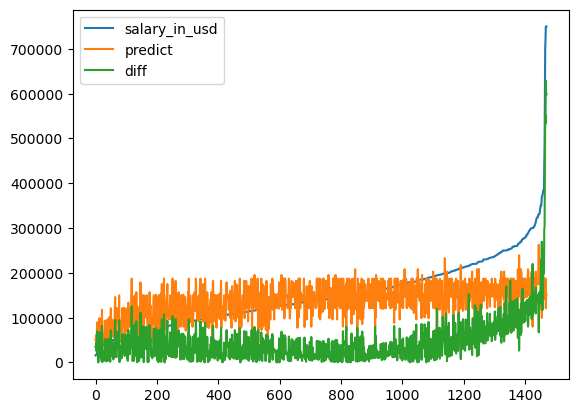

In [162]:
temp.reset_index(drop=True).plot()

<span id='xgb'></span>
### XGBoost regression with transformed and scaled target

In [146]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [148]:
xgb_pipe = Pipeline([('hot', OneHotEncoder(sparse_output=False)),
                   #('pca', PCA()),
                     ('linreg', XGBRegressor())], verbose=True) 

In [149]:
xgb_pipe.fit(x_train,y_trainT)
print('xgboost score: {}'.format(xgb_pipe.score(x_test,y_testT)))

[Pipeline] ............... (step 1 of 2) Processing hot, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=   0.5s
xgboost score: 0.382834676622377


In [150]:
xgb_predT = xgb_pipe.predict(x_test)
xgb_pred = std_y.inverse_transform(xgb_predT.reshape(-1,1))
print('xgb mae: {}'.format(mean_absolute_error(y_test,xgb_pred)))
print('xgb mse: {}'.format(mean_squared_error(y_test,xgb_pred)))
print('xgb rmse: {}'.format(np.sqrt(mean_squared_error(y_test,xgb_pred))))
print('xgb r2 score: {}'.format(r2_score(y_test,xgb_pred)))

xgb mae: 0.32134336360060944
xgb mse: 0.16486657693638135
xgb rmse: 0.40603765457945074
xgb r2 score: 0.38283472522415574


In [163]:
tempx = pd.DataFrame(y_test)
tempx['predict'] = xgb_pred
tempx.sort_values('salary_in_usd', inplace=True)#.reset_index(drop=True)#.plot()
tempx = np.exp(tempx)
tempx['diff'] = np.abs(np.diff(tempx))

In [166]:
print('In real value')
print('xgb mae: {}'.format(mean_absolute_error(tempx.salary_in_usd,tempx.predict)))
print('xgb mse: {}'.format(mean_squared_error(tempx.salary_in_usd,tempx.predict)))
print('xgb rmse: {}'.format(np.sqrt(mean_squared_error(tempx.salary_in_usd,tempx.predict))))
print('xgb r2 score: {}'.format(r2_score(tempx.salary_in_usd,tempx.predict)))

In real value
xgb mae: 46524.38128321639
xgb mse: 4679282181.135365
xgb rmse: 68405.27889816227
xgb r2 score: 0.2198911848290923


<span id='std'></span>
### Linear regression, target only standard scaled, no transformation

In [6]:
x[:3]

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,MI,FT,9,3,0,0,S
1,MI,FT,9,3,0,0,S
2,MI,CT,9,1,0,4,M


In [8]:
y = pd.read_csv('salary_clean.csv', usecols=['salary_in_usd'])

In [14]:
y = y.iloc[x.index, :]

In [17]:
std_y2 = StandardScaler()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, stratify=x.experience_level, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=.5, stratify=x_test.experience_level, random_state=69)
x_train.shape,y_train.shape,x_test.shape,x_val.shape

((6860, 7), (6860, 1), (1470, 7), (1471, 7))

In [25]:
std_y2 = std_y2.fit(np.array(y_train).reshape(-1,1))
y_trainT = std_y2.transform(np.array(y_train).reshape(-1,1))
y_testT = std_y2.transform(np.array(y_test).reshape(-1,1))
y_valT = std_y2.transform(np.array(y_val).reshape(-1,1))

In [26]:
lin_pipe2 = Pipeline([('hot', OneHotEncoder(sparse_output=False)),
                   #('pca', PCA()),
                   ('linreg', LinearRegression())], verbose=True) 
lin_pipe2.fit(x_train, y_trainT)
print('score:', lin_pipe2.score(x_test, y_testT))
predS = lin_pipe2.predict(x_test)
pred = std_y2.inverse_transform(predS)

templ = pd.DataFrame(y_test)
templ['predict'] = pred
templ.sort_values('salary_in_usd', inplace=True)#.reset_index(drop=True)#.plot()
templ['diff'] = np.abs(np.diff(templ))

print('Liner regression with no log transformation')
print('mae: {}'.format(mean_absolute_error(templ.salary_in_usd,templ.predict)))
print('mse: {}'.format(mean_squared_error(templ.salary_in_usd,templ.predict)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(templ.salary_in_usd,templ.predict))))
print('r2 score: {}'.format(r2_score(templ.salary_in_usd,templ.predict)))

[Pipeline] ............... (step 1 of 2) Processing hot, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=   0.0s
score: 0.08047130413087245
Liner regression with no log transformation
mae: 53759.487560914444
mse: 5579031523.646754
rmse: 74692.91481557507
xgb r2 score: 0.08047130413087245


<Axes: >

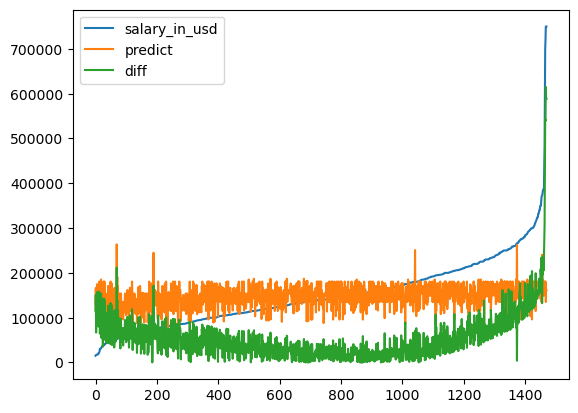

In [27]:
templ.reset_index(drop=True).plot()

<span id='rob'></span>
### Linear regression with RobustScaler on untransformed data

In [ ]:
y = pd.read_csv('salary_clean.csv', usecols=['salary_in_usd'])
y = y.iloc[x.index, :]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, stratify=x.experience_level, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=.5, stratify=x_test.experience_level, random_state=69)
print(x_train.shape,y_train.shape,x_test.shape,x_val.shape)

#=======
std_y2 = RobustScaler()
std_y2 = std_y2.fit(np.array(y_train).reshape(-1,1))
y_trainT = std_y2.transform(np.array(y_train).reshape(-1,1))
y_testT = std_y2.transform(np.array(y_test).reshape(-1,1))
y_valT = std_y2.transform(np.array(y_val).reshape(-1,1))
#======
lin_pipe2 = Pipeline([('hot', OneHotEncoder(sparse_output=False)),
                   #('pca', PCA()),
                   ('linreg', LinearRegression())], verbose=True) 
lin_pipe2.fit(x_train, y_trainT)
print('score:', lin_pipe2.score(x_test, y_testT))
predS = lin_pipe2.predict(x_test)
pred = std_y2.inverse_transform(predS)

templ = pd.DataFrame(y_test)
templ['predict'] = pred
templ.sort_values('salary_in_usd', inplace=True)#.reset_index(drop=True)#.plot()
templ['diff'] = np.abs(np.diff(templ))

print('Liner regression with no log transformation with Robustscaler')
print('mae: {}'.format(mean_absolute_error(templ.salary_in_usd,templ.predict)))
print('mse: {}'.format(mean_squared_error(templ.salary_in_usd,templ.predict)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(templ.salary_in_usd,templ.predict))))
print('r2 score: {}'.format(r2_score(templ.salary_in_usd,templ.predict)))

(6860, 7) (6860, 1) (1470, 7) (1471, 7)
[Pipeline] ............... (step 1 of 2) Processing hot, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=   0.0s
score: 0.08012712606551475
Liner regression with no log transformation with Robustscaler
mae: 53744.66771597311
mse: 5581119745.890392
rmse: 74706.8922248168
r2 score: 0.08012712606551486


<span id='rand'></span>
### Random forest wih log transformed and scaled target


In [6]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
display(x.iloc[0, :],  y[0])


experience_level      MI
employment_type       FT
job_title              9
employee_residence     3
remote_ratio           0
company_location       0
company_size           S
Name: 0, dtype: object

11.695247021764184

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, stratify=x.experience_level, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=.5, stratify=x_test.experience_level, random_state=69)
print(x_train.shape,y_train.shape,x_test.shape,x_val.shape)

#=======
std_y2 = StandardScaler()
std_y2 = std_y2.fit(np.array(y_train).reshape(-1,1))
y_trainT = std_y2.transform(np.array(y_train).reshape(-1,1))
y_testT = std_y2.transform(np.array(y_test).reshape(-1,1))
y_valT = std_y2.transform(np.array(y_val).reshape(-1,1))
#======
ran_pipe = Pipeline([('hot', OneHotEncoder(sparse_output=False)),
                   #('pca', PCA()),
                   ('reg', RandomForestRegressor())], verbose=True) 
ran_pipe.fit(x_train, y_trainT)
predT = ran_pipe.predict(x_test)
pred = std_y2.inverse_transform(predT.reshape(-1,1))

temp = pd.DataFrame(y_test)
temp['predict'] = pred
temp = np.exp(temp)
temp.sort_values('salary_in_usd', inplace=True)#.reset_index(drop=True)#.plot()
temp['diff'] = np.abs(np.diff(temp))

print('Random forest regression with log transformation and standard scaler. Real values')
print('mae: {}'.format(mean_absolute_error(temp.salary_in_usd,temp.predict)))
print('mse: {}'.format(mean_squared_error(temp.salary_in_usd,temp.predict)))
print('rmse: {}'.format(np.sqrt(mean_squared_error(temp.salary_in_usd,temp.predict))))
print('r2 score: {}'.format(r2_score(temp.salary_in_usd,temp.predict)))

(6860, 7) (6860,) (1470, 7) (1471, 7)
[Pipeline] ............... (step 1 of 2) Processing hot, total=   0.0s


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.7s
Random forest regression with log transformation and standard scaler. Real values
mae: 46388.31448360669
mse: 4676556847.481236
rmse: 68385.35550453208
r2 score: 0.22034554016086483


<Axes: >

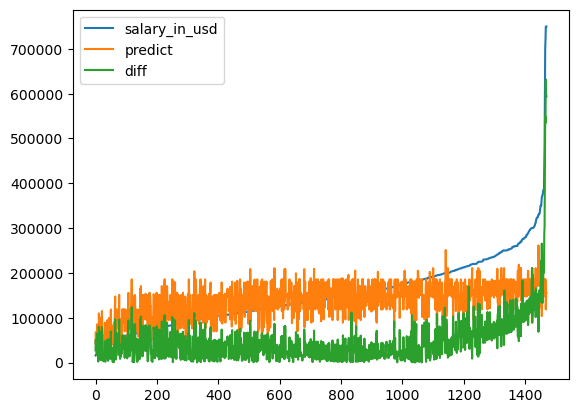

In [17]:
temp.sort_values('salary_in_usd').reset_index(drop=True).plot()